In [4]:
import matplotlib.pyplot as plt
import scipy
import numpy as np
import os 
import glob
import seaborn as sns

from PIL import Image
from scipy import ndimage


from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix

from keras import models
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.metrics import AUC

In [5]:
train_dir = '../../src/data/train'
validation_dir = '../../src/data/val'
test_dir = '../../src/data/test'


dagenerator = ImageDataGenerator(rescale=1./255)
target_size = (64, 64)
batch_size = 10
num_of_test_samples = len(glob.glob('../../src/data/test/*/*.jpg'))


train_generator = dagenerator.flow_from_directory(
        train_dir,
        target_size= target_size, 
        batch_size = batch_size)

val_generator = dagenerator.flow_from_directory(
        validation_dir,
        target_size= target_size, 
        batch_size = batch_size,
        shuffle=False)

test_generator = dagenerator.flow_from_directory(
        test_dir,
        target_size= target_size, 
        batch_size = num_of_test_samples, #All images in test set 
        shuffle=False)


# 2nd model
model = Sequential()

model.add(Conv2D(10, (3,3), activation='relu', input_shape = (64,64,3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(20, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(20, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='softmax')) # last layer has to match the amount of catagories trying to classify

model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['acc'])

history = model.fit_generator(
        generator =train_generator,
        validation_data = val_generator,
        epochs=15)

FileNotFoundError: [Errno 2] No such file or directory: '../../src/data/train'

In [ ]:
#Confution Matrix and Classification Report
num_of_val_samples = len(glob.glob('../../src/data/val/*/*.jpg'))

Y_pred = model.predict_generator(val_generator, num_of_val_samples// batch_size+1) # so it lines up with the batches
y_pred = np.argmax(Y_pred, axis=1)
target_names = ['Mild','Moderate','None','Very Mild']
print('-----------------------Classification Report-------------------')
print(classification_report(val_generator.classes, y_pred, target_names=target_names))
print('------------------------Confusion Matrix---------------------------')

conf = confusion_matrix(val_generator.classes, y_pred, normalize='true')
ax = sns.heatmap(conf, annot=True, xticklabels = target_names, yticklabels= target_names);
ax.set(xlabel='Predicted', ylabel='Actual')

# Trying method to fix class imbalance

### Adding Class weight to balance train

In [180]:
class_name = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
for i in class_name:
    print(f" {i}: {(len(glob.glob(f'../../src/data/train/{i}/*.jpg'))/4101)}")

 MildDemented: 0.1397220190197513
 ModerateDemented: 0.009997561570348696
 NonDemented: 0.4993903925871739
 VeryMildDemented: 0.3494269690319434


Epoch 1/15
411/411 [==============================] - 7s 16ms/step - loss: 5.5574 - acc: 0.4362 - auc: 0.7138 - val_loss: 1.2498 - val_acc: 0.4951 - val_auc: 0.7549
Epoch 2/15
411/411 [==============================] - 7s 17ms/step - loss: 5.0904 - acc: 0.5023 - auc: 0.7739 - val_loss: 1.1766 - val_acc: 0.4035 - val_auc: 0.7061
Epoch 3/15
411/411 [==============================] - 8s 19ms/step - loss: 4.2922 - acc: 0.5021 - auc: 0.7807 - val_loss: 0.9542 - val_acc: 0.5478 - val_auc: 0.8291
Epoch 4/15
411/411 [==============================] - 9s 22ms/step - loss: 3.3146 - acc: 0.5660 - auc: 0.8338 - val_loss: 0.8567 - val_acc: 0.5975 - val_auc: 0.8620
Epoch 5/15
411/411 [==============================] - 11s 26ms/step - loss: 2.5819 - acc: 0.6216 - auc: 0.8712 - val_loss: 0.7865 - val_acc: 0.6413 - val_auc: 0.8845
Epoch 6/15
411/411 [==============================] - 10s 23ms/step - loss: 2.1091 - acc: 0.6669 - auc: 0.8989 - val_loss: 0.7937 - val_acc: 0.6296 - val_auc: 0.8810
Epoch 7/

[Text(33.0, 0.5, 'Actual'), Text(0.5, 15.0, 'Predicted')]

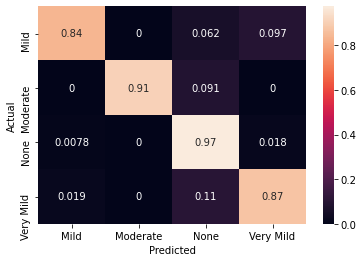

In [172]:
# another model
model_weights = Sequential()

model_weights.add(Conv2D(10, (3,3), activation='relu', input_shape = (64,64,3)))
model_weights.add(MaxPooling2D((2,2)))
model_weights.add(Conv2D(20, (3, 3), activation='relu'))
model_weights.add(MaxPooling2D((2, 2)))
model_weights.add(Conv2D(20, (3, 3), activation='relu'))
model_weights.add(Flatten())
model_weights.add(Dense(64, activation='relu'))
model_weights.add(Dense(16, activation='relu'))
model_weights.add(Dense(4, activation='softmax')) # last layer has to match the amount of catagories trying to classify

model_weights.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['acc','AUC'])

class_weight = {0:7,
                1:100,
                2:2,
                3:3}

history_weight = model_weights.fit_generator(
        generator =train_generator,
        validation_data = val_generator,
        class_weight = class_weight,
        epochs=15)

num_of_val_samples = len(glob.glob('../../src/data/val/*/*.jpg'))

Y_pred = model_weights.predict_generator(val_generator, num_of_val_samples// batch_size+1) # so it lines up with the batches
y_pred = np.argmax(Y_pred, axis=1)
target_names = ['Mild','Moderate','None','Very Mild']
print('-----------------------Classification Report-------------------')
print(classification_report(val_generator.classes, y_pred, target_names=target_names))
print('------------------------Confusion Matrix---------------------------')

conf = confusion_matrix(val_generator.classes, y_pred, normalize='true')
ax = sns.heatmap(conf, annot=True, xticklabels = target_names, yticklabels= target_names);
ax.set(xlabel='Predicted', ylabel='Actual')

This fixed the problems I was having with the class imbalance without haveing to do data augmentation or other methods. It basically got the same accuracy score 

In [174]:
test_predictions = np.argmax(model_weights.predict(test_generator), axis=1)

In [175]:
test_predictions

array([0, 0, 0, 3, 3, 0, 3, 2, 0, 0, 2, 3, 3, 3, 2, 3, 0, 3, 3, 2, 3, 0,
       0, 0, 3, 2, 3, 3, 2, 3, 0, 3, 2, 2, 3, 2, 3, 3, 2, 3, 3, 3, 2, 3,
       0, 3, 2, 2, 3, 0, 0, 2, 3, 2, 3, 3, 2, 3, 3, 3, 2, 2, 3, 2, 0, 3,
       3, 0, 3, 3, 3, 3, 2, 2, 3, 3, 2, 0, 3, 2, 3, 2, 3, 3, 3, 3, 2, 3,
       2, 2, 3, 2, 0, 3, 3, 2, 3, 2, 2, 3, 2, 2, 3, 2, 3, 0, 2, 2, 3, 2,
       3, 3, 3, 2, 2, 3, 2, 3, 2, 2, 3, 2, 3, 2, 3, 2, 2, 3, 2, 2, 2, 2,
       3, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 3, 2, 3, 2, 3, 2,
       2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       2, 2, 2, 2, 2, 3, 3, 2, 2, 3, 3, 2, 2, 2, 2,

In [176]:
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

[Text(33.0, 0.5, 'Actual'), Text(0.5, 15.0, 'Predicted')]

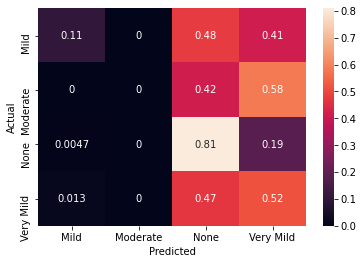

In [179]:
conf = confusion_matrix(test_generator.classes, test_predictions, normalize='true')
ax = sns.heatmap(conf, annot=True, xticklabels = target_names, yticklabels= target_names);
ax.set(xlabel='Predicted', ylabel='Actual')

In [ ]:
# Unsure why model performed so poorly on test data. Going to try using image augmentation to upsample the minoirity class